In [42]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

TRAIN_DIR =r'C:\Users\Gabi\Desktop\train'
TEST_DIR = r'C:\Users\Gabi\Desktop\test'
IMG_SIZE = 50

### Creating a function to decide dog or cat

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return 0
    elif word_label == 'dog': return 1

### Creating the data train

In [3]:
def creat_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

In [4]:
train_data = creat_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [04:07<00:00, 101.09it/s]
C:\Users\Gabi\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [5]:
X = np.array([i[0] for i in train_data]).reshape(25000,2500)
Y = [i[1] for i in train_data]

In [23]:
## function that you can see the pictures 50_50 size
images_50_50 = pd.DataFrame(X)

# this function plot image from the data
def image_plot(images_set, Y_labels, image_number, size=50):
    images = images_set.values
    images = images.reshape(-1, size, size)
    img = images[image_number]
    plt.imshow(img,cmap='gray')
    plt.title("class " + str(image_number))

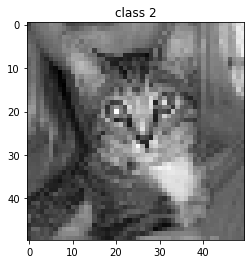

In [24]:
### exampels for the pictures
image_plot(images_50_50, Y, 2)

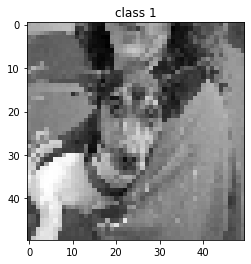

In [27]:
image_plot(images_50_50, Y, 1)

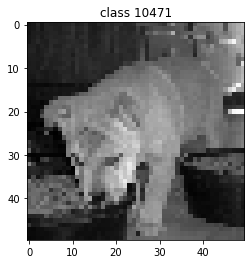

In [28]:
image_plot(images_50_50, Y,10471)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
     X, Y, test_size=0.2, random_state=42)

### Finding the numbers of dimntions (i chose 90 pracent because it is a big data)

In [30]:
pca = PCA()
XDR = pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.90) + 1

In [31]:
d

289

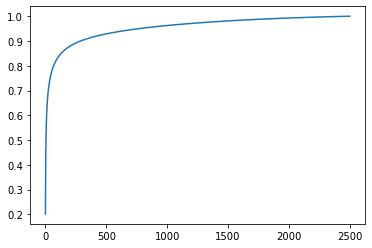

In [32]:
plt.plot(cumsum)

### Fitting ad transforming the new train after pca

In [33]:
from sklearn.decomposition import IncrementalPCA
n_batches = 40
inc_pca = IncrementalPCA(n_components=289)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_train = inc_pca.transform(X_train)

In [34]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

### Transforming the test

In [35]:
X_test = inc_pca.transform(X_test)
X_test = sc.fit_transform(X_test)

### Using Xgboost to predict the data

In [36]:
xgb_clf = xgb.XGBClassifier(eval_metric = 'mlogloss')
xgb_clf.fit(X_train, y_train)

C:\Users\Gabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [43]:
xgb_clf.score(X_test, y_test)

0.6328

In [50]:
xgb_kmeans = Pipeline([
    ("kmeans", KMeans(n_clusters=16)), 
    ("xgb_clf", xgb.XGBClassifier(use_label_encoder=False))
])

In [51]:
xgb_kmeans.fit(X_train, y_train)

[18:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('kmeans', KMeans(n_clusters=16)),
                ('xgb_clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [52]:
xgb_kmeans.score(X_test, y_test)

0.5106

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb_params_search = [
    
    {
     'eta': [0.1, 0.3, 0.5, 1],
     'booster':['gbtree','gblinear','dart'],
     'gamma': list(range(0,100, 20)),
     'max_depth': list(range(5,100, 15)),
     'subsample': [0.3, 0.6,1],
        
    }
    
]
random_search_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=xgb_params_search,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    n_iter=60)
random_search_xgb.fit(X=X_train,y=y_train)

C:\Users\Gabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:46:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:46:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parame

[21:54:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:02:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parame

[23:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parame

In [ ]:
xgb_clf_best = random_search_xgb.best_estimator_.fit(X=X_train,y=y_train)

In [ ]:
xgb_clf_best.score(X_test, y_test)

### Finding the best k before using knn

In [154]:
err_rate=[] 
for i in range(1,100):
    k=KNeighborsClassifier(n_neighbors=i)
    k.fit(X_train,y_train)
    bestK=k.predict(X_test)
    err_rate.append(np.mean(bestK != y_test))

Text(0, 0.5, 'Accuracy')

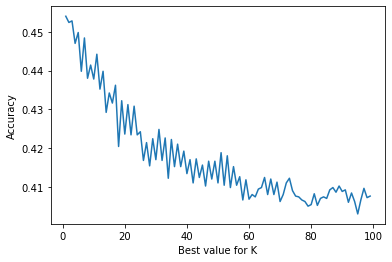

In [155]:
plt.plot(range(1,100),err_rate)
plt.xlabel('Best value for K')
plt.ylabel('Accuracy')

### Using knn with the best k , the knn is not so got but it is helping to the stacking.

In [438]:
from sklearn.ensemble import BaggingClassifier
knn = KNeighborsClassifier(n_neighbors=96).fit(X_train, y_train)

In [439]:
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5016


### Training the random forest and using bagging

In [447]:
ranfor = BaggingClassifier(base_estimator=RandomForestClassifier(),
                      n_estimators=10, random_state=0).fit(X_train, y_train)

In [448]:
ranfor.predict(X_test)
ranfor.score(X_test,y_test)

0.637

### Using also adaboost before the stacking.

In [426]:
from sklearn.ensemble import AdaBoostClassifier
ad =AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME')

In [427]:
ad.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME')

In [428]:
ad.predict(X_test)
ad.score(X_test,y_test)

0.5896

### Using decision tree model with baggibg for a better result.

In [443]:
dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=0),n_estimators=10, random_state=0).fit(X_train, y_train)

In [444]:
dt.predict(X_test)
dt.score(X_test,y_test)

0.573

### Showing that by using voting the result is les good, when voting is on hard(with the knn and without) the  results are Less good.

In [310]:
from sklearn.metrics import accuracy_score

In [311]:
voting_clf = VotingClassifier(
 estimators=[('xg', xgb_clf ),('ad', ad),('rn',ranfor),('dt',dt)],
 voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(accuracy_score(y_pred, y_test))

C:\Users\Gabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.617


In [453]:
estimators = [('xg', xgb_clf ),('ad', ad),('rn',ranfor),('dt',dt)]

### By using stacking with the wick learners models im getting a better result

In [454]:
from sklearn.ensemble import StackingClassifier

In [457]:
stclf= StackingClassifier(
   estimators=estimators, final_estimator=knn)

In [458]:
stclf.fit(X_train, y_train).score(X_test, y_test)

C:\Users\Gabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6472